# ReAct Demo
## ReAct 模式（Reason + Act）的背景说明

ReAct（**Reason + Act**）是一种用于构建智能 Agent 的交互范式，其核心思想是：**让大语言模型在“推理（Reasoning）”与“行动（Action）”之间交替进行**，而不是一次性生成最终答案。

在 ReAct 模式下，LLM 不再只是被动地产生文本，而是：

1. **先理解用户意图并进行推理**（例如判断是否需要外部信息）；
2. **在需要时主动调用外部工具或系统能力**（Action），如 API、数据库或第三方服务；
3. **接收工具返回的真实世界信息**；
4. **基于反馈继续推理并生成最终回答**。

这种 “推理 → 行动 → 反馈 → 再推理” 的闭环，使 Agent 能够突破纯语言模型的局限，获取**实时信息、外部状态或计算结果**，从而完成更真实、更可靠的任务。

在本示例中，Agent 通过 ReAct 模式判断用户是否在询问“当前时间”，并在需要时调用时间获取工具，最后将工具返回的结果整合为自然语言回复，展示了 **LLM 自主决策 + 外部执行 + 结果整合** 的完整 Agent 工作流程。


In [19]:
import os
from langchain_openai import ChatOpenAI

deepseek_chat = ChatOpenAI(
    model="deepseek-chat",
    api_key=os.environ["DEEPSEEK_API_KEY"],
    base_url="https://api.deepseek.com",
    temperature=0,
)
response = deepseek_chat.invoke("Hello, what time it is now?")
print(response.content)

I don’t have access to real-time information, so I can’t provide the current time. You can check the time on your device, ask a voice assistant, or look at a clock nearby. If you’re in a specific time zone, I can help you calculate it based on UTC if needed!


In [14]:
# -*- coding: utf-8 -*-
"""
LangGraph ReAct-style demo:
- node1 is an LLM node
- tool_get_local_time is registered as a tool
- LLM decides when to call tool, tool result is fed back, then LLM answers

Requirements:
pip install langgraph langchain-openai langchain-core pendulum
"""

from __future__ import annotations

import os
import pendulum
from typing import TypedDict, Annotated, List

from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages


# -----------------------------
# 1) State: use messages list (ReAct/tool-calling friendly)
# -----------------------------
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]


# -----------------------------
# 2) Tool: "third-party" time provider (here pendulum is the provider)
#    You can swap it to a real API later without changing graph logic.
# -----------------------------
@tool
def tool_get_local_time(tz: str | None = None) -> str:
    """
    Get the current time.
    Args:
        tz: IANA timezone name, e.g. "America/Los_Angeles", "Asia/Shanghai".
            If omitted, use local timezone.
    Returns:
        A datetime string with timezone info.
    """
    if tz:
        now = pendulum.now(tz)
    else:
        now = pendulum.now()  # local
    return now.to_iso8601_string()


# -----------------------------
# 3) LLM: bind tools to enable tool-calling
# -----------------------------
llm = ChatOpenAI(
    model="deepseek-chat",
    api_key=os.environ["DEEPSEEK_API_KEY"],
    base_url="https://api.deepseek.com",
    temperature=0,
).bind_tools([tool_get_local_time])


# -----------------------------
# 4) Nodes
# -----------------------------
SYSTEM_PROMPT = (
    "You are an assistant that can answer questions and may call tools.\n"
    "If the user asks for current time, timezone conversion, 'now', '几点', "
    "'北京时间/洛杉矶时间' etc., you should call tool_get_local_time.\n"
    "If user didn't specify timezone but implies one (e.g. '北京时间'), pass an appropriate tz.\n"
    "If no timezone is implied, you may call the tool without tz.\n"
    "After tool result, answer concisely and clearly."
)

def node1_llm(state: AgentState) -> AgentState:
    # Always include a system message for consistent behavior
    msgs = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    ai_msg = llm.invoke(msgs)
    return {"messages": [ai_msg]}


tool_node = ToolNode([tool_get_local_time])


# -----------------------------
# 5) Routing: if LLM asked to call tool -> tool node, else end
# -----------------------------
def route_after_llm(state: AgentState) -> str:
    last = state["messages"][-1]

    # 1) OpenAI-style: additional_kwargs["tool_calls"]
    ak = getattr(last, "additional_kwargs", {}) or {}
    tool_calls = ak.get("tool_calls")

    # 2) LangChain normalized: last.tool_calls  (你这里就是这种)
    if not tool_calls:
        tool_calls = getattr(last, "tool_calls", None)

    return "tools" if tool_calls else END



# -----------------------------
# 6) Build graph
# -----------------------------
graph = StateGraph(AgentState)
graph.add_node("node1", node1_llm)
graph.add_node("tools", tool_node)

graph.set_entry_point("node1")
graph.add_conditional_edges("node1", route_after_llm, {"tools": "tools", END: END})
graph.add_edge("tools", "node1")  # tool result -> back to LLM for final answer

agent = graph.compile()


# -----------------------------
# 7) Simple test runner
# -----------------------------
def run(query: str):
    out = agent.invoke({"messages": [HumanMessage(content=query)]})
    # Print final assistant content (last AI message)
    final_msg = out["messages"][-1]
    print(final_msg.content)

In [15]:
run("现在几点？")
    

现在是北京时间 2026年1月9日 16:04。


In [16]:
run("给我纽约时间")

现在是纽约时间 2026年1月9日 凌晨3:04（东部标准时间）。


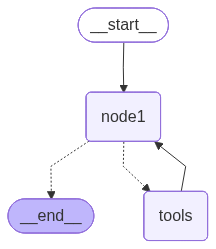

In [17]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

很好，这一行其实**把 LangGraph 的“状态机制”最关键的三件事全放进来了**。我按**由浅入深、从 Python → LangGraph**的顺序给你解释，适合你直接拿去讲 ReAct / Agent 架构。

---

## 1️⃣ `TypedDict`：给 Agent State 一个**结构化的“契约”**

```python
class AgentState(TypedDict):
    messages: ...
```

### 它是什么？

`TypedDict` 是 Python `typing` 里的一个工具，用来**描述“这个 dict 应该长什么样”**。

* 运行时：它 **还是一个普通的 dict**
* 类型层面：它告诉人和 IDE / 类型检查器
  👉 *Agent 的状态里应该有哪些字段、每个字段是什么类型*

### 在 Agent 里的作用

在 LangGraph 中，**State 就是节点之间传递的“共享记忆”**。

```python
state = {
    "messages": [...]
}
```

用 `TypedDict` 的好处是：

* 明确规定：

  > **这个 Agent 的状态只有一个字段：messages**
* 防止状态在节点间“随意膨胀”
* IDE / 静态检查能发现拼写错误或类型错误

你可以把它类比为：

> **AgentState 是节点之间通信的“接口定义”**

---

## 2️⃣ `Annotated`：给字段加**“语义标签”**

```python
messages: Annotated[List[BaseMessage], add_messages]
```

### 它是什么？

`Annotated` 是 Python 的 **类型 + 元数据** 机制：

```python
Annotated[T, X]
```

含义是：

> 这个字段的**类型是 `T`**，
> 同时附带一个 **额外的语义说明 `X`**

⚠️ 注意：

* Python 本身 **不会** 使用 `X`
* 但 **LangGraph 会读取这个“注解”**

---

## 3️⃣ `add_messages`：LangGraph 的**状态合并规则**

这是最关键的一部分。

```python
from langgraph.graph.message import add_messages
```

### 它的含义（一句话）

> **当多个节点返回 `messages` 时，不是覆盖，而是“追加”到对话历史中**

### 如果没有 `add_messages` 会发生什么？

假设没有 Annotated：

```python
class AgentState(TypedDict):
    messages: List[BaseMessage]
```

那么：

* node1 返回 `{"messages": [AIMessage(...)]}`
* tool node 返回 `{"messages": [ToolMessage(...)]}`

👉 **后一个会直接覆盖前一个**

对话历史就断了 ❌
ReAct 直接崩掉 ❌

---

### `add_messages` 做了什么？

它告诉 LangGraph：

> 这个字段是 **“消息序列”**，
> 新值 = 旧值 + 新值

等价于：

```python
state["messages"].extend(new_messages)
```

### 所以这一行的真实含义是：

> `messages` 是一个对话消息列表，
> 每个节点都可以往里面**追加**新消息，
> LangGraph 负责自动合并。

---

## 4️⃣ 把三者合起来，用一句“架构级”解释

```python
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
```

可以翻译成一句**非常适合讲给别人听的话**：

> AgentState 是一个结构化的状态对象，其中 `messages` 表示跨节点共享的对话历史；
> 该字段由 LangGraph 以“追加而非覆盖”的方式自动维护，从而支持 ReAct 风格的多轮推理与工具调用。

---

## 5️⃣ 为什么 ReAct / Tool Calling **必须**用这种写法？

因为 ReAct 的核心是：

```
User →
LLM →
Tool →
LLM →
Tool →
LLM →
Final Answer
```

每一步都依赖**完整历史**：

* LLM 要看到用户原始问题
* LLM 要看到自己刚刚发起的 tool call
* LLM 要看到 tool 的返回结果

`Annotated[..., add_messages]` 正是 **“多步 reasoning 的内存机制”**。

---

## 6️⃣ 一句话总结

> `TypedDict` 定义 Agent 状态结构，`Annotated` 为字段附加语义，而 `add_messages` 指定了消息字段的合并规则，使 LangGraph 能够自动维护跨节点的对话历史，是 ReAct Agent 能正常工作的关键机制。

如果你愿意，我也可以帮你把这段解释**压缩成 3 行 code comment 版**，直接写在代码上方，特别适合教学示例。
